In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [484]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.svm import SVC
from collections import Counter
from scipy.stats import entropy as calculate_entropy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


### utilities

In [377]:
def sigmoid(x):
#     return x / (x+1)
    return 1 / (1 + (np.e**-x))

def infer_topic(doc_vector, topic_word_distr, threshold=None):
    doc_topic_word_distr = topic_word_distr.copy()
    
    if threshold is None:
        doc_word_freq_norm = doc_vector
        
    else:
        doc_word_freq_norm = (doc_vector > threshold).astype(int)
   
    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [378]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

### clean dataset

In [379]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [433]:
labels = []
clean_docs = []

# the new classes
# label_classes = ['sci/comp', 'other']
label_classes = list(set([x.split('.')[0] for x in classes]))

for index, doc in enumerate(docs):
    cd = clean_doc(doc)
    
    if cd and not cd.isspace():
        clean_docs.append(cd)
        
        cl = classes[old_labels[index]]
#         if cl in ['sci', 'comp']:
#             labels.append(0)
            
#         else:
#             labels.append(1)
        labels.append(label_classes.index(cl.split('.')[0]))

labels = np.array(labels)   
print(clean_docs[0])

morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher


In [434]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 973 docs and 7 classes: ['sci', 'alt', 'rec', 'talk', 'soc', 'misc', 'comp']


### count words

In [506]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)
count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 14988


### Prepare Datatset

In [507]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
# train_doc_vectors = (train_doc_vectors > 0).astype('float')
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
# train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=0)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
# test_doc_vectors = (test_doc_vectors > 0).astype('float')
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)
# test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=0)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

651 train_docs, 322 test docs


In [508]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (651, 14989)


In [509]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 973 docs and 7 classes


In [510]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zombo,zone,zoom,zooming,zubov,zum,zx,zx900a,zzz,__labels__
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


### Prepare Binary Dataset

In [511]:
#reduce freq in doc to bin value of 1 or 0
word_doc_frequency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0) 

### Topic and word corelation

In [512]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

print("Building Topic word Distr!")

for topic in tqdm(range(len(label_classes))):
    label = label_classes[topic]
    
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    
#     trust_factor = sigmoid()#(len(np.where(train_labels == topic)[0]))
    topic_word_distr[label] = (word_topic_frequency / word_doc_total_frequency).fillna(0)
    
               
# print("Normalizing...")
# topic_word_distr = (topic_word_distr.T * (1 - sigmoid(np.nan_to_num(calculate_entropy(topic_word_distr, base=2, axis=1))))).T
# topic_word_distr = (topic_word_distr.T * (1 - sigmoid(topic_word_distr.std(1)))).T
# print("Done...")
print(f"topic_word_distr has shape {topic_word_distr.shape}")

Building Topic word Distr!



topic_word_distr has shape (14988, 7)


In [513]:
topic_word_distr.shape

(14988, 7)

In [514]:
word = "companies"
topic_word_distr.loc[word].sort_values(ascending=False)

rec     0.5
sci     0.5
comp    0.0
misc    0.0
soc     0.0
talk    0.0
alt     0.0
Name: companies, dtype: float64

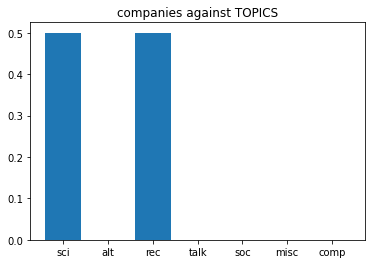

In [515]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluating Topic Model

In [516]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)

train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%\n")

Evaluating Topic Model...



==> train-accuracy is 73.27%



### Testing Topic Model

In [517]:
score = 0
misclassified_test = []
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuracy is {.5*(train_accuracy+test_accuracy)*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 50.00%, avg-accuracy is 61.64%



In [518]:
index = 0
label = label_classes[train_labels[misclassified_train[index]]]
doc_vector = train_doc_vectors[misclassified_train[index]]
doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr)

print(f"predicted = {doc_topic}, actual = {label}")
print("="*50)
print(clean_docs[misclassified_train[index]])
doc_topic_word_distr.loc[doc_topic_word_distr.sum(1).sort_values(ascending=False).index]
# doc_topic_word_distr.sum(1).sort_values(ascending=False)

predicted = comp, actual = soc
hello world,  i want to write my xt-application code like this:        do_some_work  ;     /* now i need some user input */     xmcreatedialog  ;     wait_for_user_input input ;     if  input ==  ok            more_work  ;       else          other_work  ;          so  more_work   and other_work    are not in callback functions but the application simply waits for the user to answer the question.  how can i code this in my xt/motif-application?  thanks very much in advance.  greetings, huub.


,sci,alt,rec,talk,soc,misc,comp
to,0.015205,0.002603,0.015068,0.011781,0.003699,0.002603,0.017534
the,0.009254,0.001457,0.009691,0.007141,0.001967,0.001457,0.010128
he,0.005815,0.001163,0.014732,0.011631,0.004652,0.000388,0.002714
that,0.008199,0.001366,0.007857,0.006320,0.002220,0.000512,0.007772
is,0.006338,0.000990,0.005678,0.004753,0.001584,0.001056,0.006998
...,...,...,...,...,...,...,...
overlap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
overland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
overkill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
overheard,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [448]:
doc_topic_word_distr.max(1).sort_values(ascending=False)

keith           0.160667
librarian       0.147778
childhood       0.147778
polio           0.147778
actrix          0.147778
                  ...   
overheard       0.000000
overhead        0.000000
overextended    0.000000
overdose        0.000000
00              0.000000
Length: 14988, dtype: float64

In [449]:
topic_word_distr.loc["keith"]

sci     0.333333
alt     0.000000
rec     0.666667
talk    0.000000
soc     0.000000
misc    0.000000
comp    0.000000
Name: keith, dtype: float64

### LogisticRegression

In [450]:
logistic_regression_model = LogisticRegression(
    random_state=0, 
#     fit_intercept=False,
#     multi_class="multinomial", 
#     solver="lbfgs"
)

logistic_regression_model = SVC(kernel='linear', gamma='auto')

In [451]:
word = "computer"
word_index = vocabulary.index(word)
logistic_regression_model.fit(train_doc_vectors[:, word_index:word_index+1], train_labels)

print(f"{len(train_labels)} training sample(s), {len(test_labels)} test sample(s)")

651 training sample(s), 322 test sample(s)


In [452]:
train_accuracy = logistic_regression_model.score(train_doc_vectors[:, word_index:word_index+1], train_labels)
test_accuracy = logistic_regression_model.score(test_doc_vectors[:, word_index:word_index+1], test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%")

training_accuarcy = 25.50%, test_accuarcy = 28.26%


In [453]:
label_class = 'comp'
np.array(vocabulary)[logistic_regression_model.coef_[label_classes.index(label_class)].argsort()][::-1]

array(['00'], dtype='<U79')

In [454]:
word="keyboard"
relation = pd.DataFrame(data=logistic_regression_model.coef_[:, vocabulary.index(word)].reshape((1,7)), columns=label_classes).T[0]
relation.sort_values(ascending=False)

IndexError: index 7952 is out of bounds for axis 1 with size 1

In [ ]:
plt.title(f"{word} against TOPICS")
plt.bar(relation.index, relation)
plt.show()

In [455]:
logistic_regression_model.coef_

array([[ 0.00000000e+00],
       [ 3.62798137e-01],
       [ 0.00000000e+00],
       [ 1.55602500e-09],
       [ 3.45882260e-03],
       [-7.27949867e-10],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.14150503e-02],
       [-2.46403644e-01],
       [-7.51982022e-10],
       [-5.62007712e-02],
       [-2.71189365e-01],
       [ 0.00000000e+00],
       [-2.14988594e-01],
       [-3.55087859e-03],
       [-8.51983145e-09]])

In [505]:
1/100

0.01

0.0000 <= computer <= 0.0002, entropy = 1.7170, topic = comp


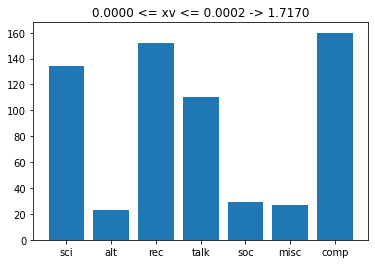

0.0011 <= computer <= 0.0012, entropy = 0.0000, topic = rec


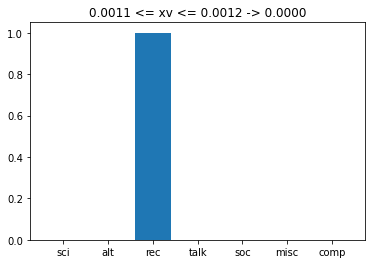

0.0017 <= computer <= 0.0018, entropy = 0.0000, topic = sci


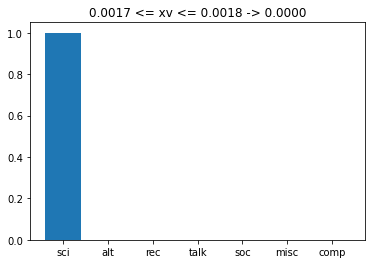

0.0032 <= computer <= 0.0033, entropy = 0.0000, topic = comp


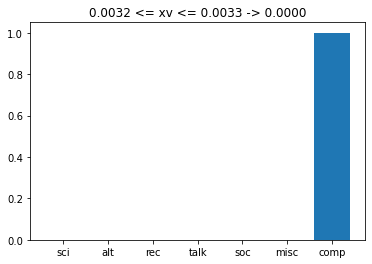

0.0035 <= computer <= 0.0036, entropy = 0.0000, topic = soc


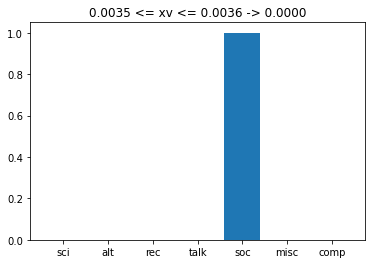

0.0044 <= computer <= 0.0045, entropy = 0.6931, topic = comp


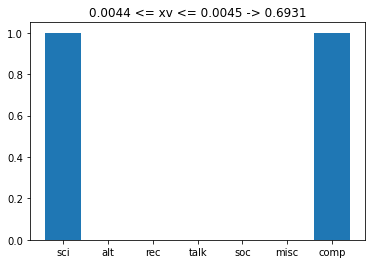

0.0055 <= computer <= 0.0056, entropy = 0.0000, topic = comp


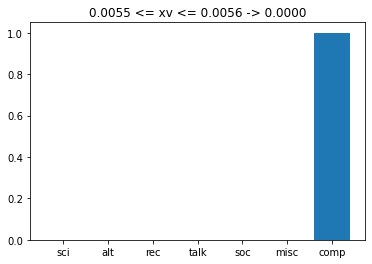

0.0070 <= computer <= 0.0071, entropy = 0.0000, topic = misc


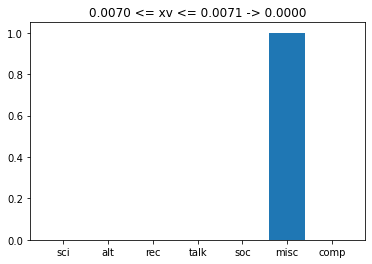

0.0074 <= computer <= 0.0076, entropy = 0.0000, topic = comp


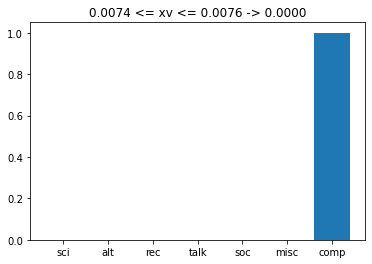

0.0085 <= computer <= 0.0086, entropy = 0.0000, topic = comp


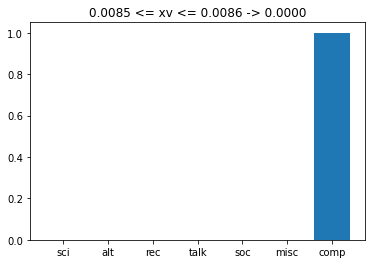

0.0086 <= computer <= 0.0088, entropy = 0.0000, topic = sci


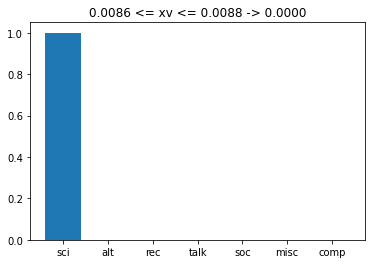

0.0094 <= computer <= 0.0095, entropy = 0.0000, topic = misc


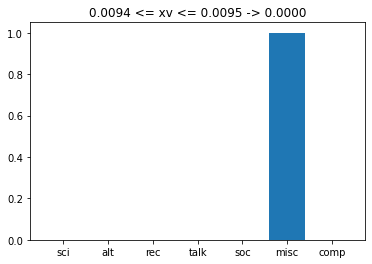

0.0127 <= computer <= 0.0129, entropy = 0.6931, topic = sci


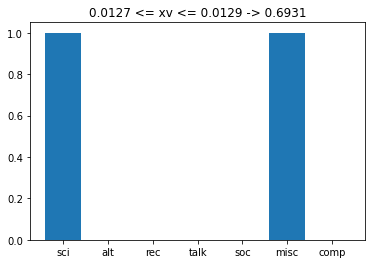

0.0135 <= computer <= 0.0136, entropy = 0.0000, topic = comp


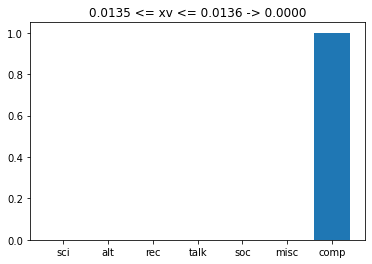

In [530]:
N = 100

word = "computer"
word_index = vocabulary.index(word)

xv = train_doc_vectors[:, word_index]
mesh = np.linspace(xv.min(), xv.max(), N+1)

for i in range(1, N):
    a, b = mesh[i-1:i+1]

    count = Counter(train_labels[(xv >= a) & (xv <= b)])
    clx, values = [], []
    for index, label in enumerate(label_classes):
        clx.append(label)
        values.append(count.get(index, 0))

    if not any(values):
        continue

    entropy = calculate_entropy(values)
    topic = count.most_common(1)[0][0]
    print(f"{a:.4f} <= {word} <= {b:.4f}, entropy = {entropy:.4f}, topic = {label_classes[topic]}")
    
    plt.title(f"{a:.4f} <= xv <= {b:.4f} -> {entropy:.4f}")
    plt.bar(clx, values)
    plt.show()

In [ ]:
N = 100

model = {}

for word_index in tqdm(range(len(vocabulary))):
    word = vocabulary[word_index]
    
    #the decision model
    model[word] = {}
    
    xv = train_doc_vectors[:, word_index]
    mesh = np.linspace(xv.min(), xv.max(), N+1)

    for i in range(1, N):
        a, b = mesh[i-1:i+1]

        count = Counter(train_labels[(xv >= a) & (xv <= b)])
        clx, values = [], []
        for index, label in enumerate(label_classes):
            clx.append(label)
            values.append(count.get(index, 0))

        if not any(values):
            continue

        entropy = calculate_entropy(values)
        topic = count.most_common(1)[0][0]
#         print(f"{a:.4f} <= {word} <= {b:.4f}, entropy = {entropy:.4f}, topic = {label_classes[topic]}")
        
        model[word][tuple([a, b])] = {"topic":topic, "entropy":entropy}

In [422]:
label_classes

['sci', 'alt', 'rec', 'talk', 'soc', 'misc', 'comp']